# 大语言模型-推理采样(Sampling)

练习目标：
* 理解推理采样概念
* 调节温度对采样的影响
* 采样顺序对结果的影响

相关文章链接：[LLM推理采样(Sampling)常见知识概览](https://zhuanlan.zhihu.com/p/1981752176578667658)

Author: kaiyuan

Email: kyxie@zju.edu.cn

## 1 常见的采样函数

**练习思路：** 构建基本采样函数，完成一个采样示例。

输入定义，字符与logits值：

labels = ['A', 'B', 'C', 'D', 'E', 'F']

original_logits = [2.0, 1.0, 0.5, 0.1, -1.0, -2.0]


应用采样处理：

* **输入：** 'A' 到 'F' 标签的初始 original_logits 定义为 [2.0, 1.0, 0.5, 0.1, -1.0, -2.0]。

* **惩罚（penalty）：** 对标签 'A' 和 'E' 施加 1.5 的惩罚，使它们的逻辑值分别降低至 0.5（从 2.0）和 -2.5（从 -1.0），从而有效降低了它们被选中的可能性。
* **偏置（bias）：** 对标签 'C' 和 'D' 施加 0.8 的偏置，使它们的逻辑值分别增加至 1.3（从 0.5）和 0.9（从 0.1），提高了它们的概率。
* **温度（Temperature）：** 使用 0.5 的温度缩放 放大了逻辑值之间的差异，使得较高的逻辑值更高（例如，'C' 从 1.3 变为 2.6），较低的逻辑值更低，从而锐化了概率分布。
* **Softmax：** Softmax 转换后，概率为 [0.092, 0.249, 0.454, 0.204, 0.0002, 0.0006]，其中 'C' 的概率最高（0.454），其次是 'B'（0.249）和 'D'（0.204）。
* **Top-K：** 使用 K=3 的 Top-K 过滤，仅保留了三个最高概率的 token（'C', 'B', 'D'），其他设为零。重新归一化后，它们的概率变为 [0.0, 0.275, 0.500, 0.225, 0.0, 0.0]。
* **Top-p：** 在初始 softmax 概率上应用 P=0.7 的 Top-P 过滤，由于它们的累积概率超过了 0.7，同样选择了相同的 token 集（'C', 'B', 'D'）。这导致了与 Top-K 过滤器相同的重新归一化概率：[0.0, 0.275, 0.500, 0.0, 0.0, 0.0]。

* **加权采样：** 加权采样 步骤，使用 Top-K 过滤后获得的概率进行，最终采样到了 token 'C'。

每步都绘制输出结果。


In [ ]:
import numpy as np


# 使用numpy库，定义采样函数：

def softmax(x):
    """计算softmax"""
    exp_x = np.exp(x - np.max(x))  # 减去最大值以防止数值溢出
    return exp_x / np.sum(exp_x)

def apply_penalty(logits, penalty_strength, penalized_indices):
    """
    对指定的logits应用惩罚。
    :param logits: 原始logits的numpy数组。
    :param penalty_strength: 浮点数，从受惩罚的logits中减去的值。
    :param penalized_indices: 要施加惩罚的索引列表或数组。
    :return: 经过惩罚修改后的logits的numpy数组。
    """
    modified_logits = np.copy(logits)
    for idx in penalized_indices:
        if 0 <= idx < len(modified_logits):
            modified_logits[idx] -= penalty_strength
    return modified_logits

def apply_bias(logits, bias_strength, biased_indices):
    """
    对指定的logits应用偏置。
    :param logits: 原始logits的numpy数组。
    :param bias_strength: 浮点数，添加到偏置logits中的值。
    :param biased_indices: 要施加偏置的索引列表或数组。
    :return: 经过偏置修改后的logits的numpy数组。
    """
    modified_logits = np.copy(logits)
    for idx in biased_indices:
        if 0 <= idx < len(modified_logits):
            modified_logits[idx] += bias_strength
    return modified_logits

def apply_temperature(logits, temperature):
    """
    对logits应用温度缩放。
    :param logits: 原始logits的numpy数组。
    :param temperature: 浮点数，缩放因子。必须大于0。
    :return: 经过温度缩放的logits的numpy数组。
    """
    if temperature <= 0:
        raise ValueError("Temperature必须大于0。")
    return logits / temperature

def top_k_filter(probabilities, k):
    """
    对probabilities应用Top-K过滤。
    :param probabilities: 概率的numpy数组。
    :param k: 整数，要保留的Top K个概率的数量。
    :return: 经过过滤和重新归一化的概率的numpy数组。
    """
    if k <= 0:
        return np.zeros_like(probabilities)
    if k >= len(probabilities):
        # 如果K大于或等于probabilities的长度，则只进行重新归一化以处理可能的浮点误差
        return probabilities / np.sum(probabilities)

    # 获取按降序排列的概率索引
    sorted_indices = np.argsort(probabilities)[::-1]
    # 获取Top K个索引
    topk_indices = sorted_indices[:k]

    # 创建一个新的过滤后概率数组，初始化为零
    filtered_probs = np.zeros_like(probabilities)
    # 将Top K个概率复制到其原始位置
    filtered_probs[topk_indices] = probabilities[topk_indices]

    # 重新归一化选定的概率
    sum_filtered_probs = np.sum(filtered_probs)
    if sum_filtered_probs > 0:
        filtered_probs /= sum_filtered_probs

    return filtered_probs

def top_p_filter(probabilities, p):
    """
    对probabilities应用Top-P (nucleus) 过滤。
    :param probabilities: 概率的numpy数组。
    :param p: 浮点数，累积概率阈值 (0 < p <= 1)。
    :return: 经过过滤和重新归一化的概率的numpy数组。
    """
    if not (0 < p <= 1):
        raise ValueError("p必须在0到1之间。")

    # 按降序对概率排序并获取其原始索引
    sorted_indices = np.argsort(probabilities)[::-1]
    sorted_probs = probabilities[sorted_indices]

    # 计算累积和
    cumulative_probs = np.cumsum(sorted_probs)

    # 找到累积和大于或等于p的最小概率集合
    nucleus_indices_mask = cumulative_probs <= p
    # 如果即使第一个元素也大于p，或者累积和刚好在p以下，需要额外处理
    if not np.any(nucleus_indices_mask) and len(sorted_indices) > 0:
        # 如果没有累积和小于p的元素，则至少保留最高的概率
        nucleus_indices = sorted_indices[:1]
    else:
        # 找出满足条件的索引
        valid_indices_count = np.sum(nucleus_indices_mask)
        if valid_indices_count < len(sorted_indices) and cumulative_probs[valid_indices_count - 1] < p:
            # 如果在p以下截断，添加下一个最高概率的token
            nucleus_indices = sorted_indices[:valid_indices_count + 1]
        else:
            nucleus_indices = sorted_indices[:valid_indices_count]

    # 创建一个新的过滤后概率数组，初始化为零
    filtered_probs = np.zeros_like(probabilities)
    # 将选定的概率复制到其原始位置
    filtered_probs[nucleus_indices] = probabilities[nucleus_indices]

    # 重新归一化选定的概率
    sum_filtered_probs = np.sum(filtered_probs)
    if sum_filtered_probs > 0:
        filtered_probs /= sum_filtered_probs

    return filtered_probs

def weighted_sample(probabilities, labels):
    """
    根据给定的概率分布随机选择一个label。
    :param probabilities: 概率的numpy数组，总和为1。
    :param labels: 对应的标签列表或数组。
    :return: 采样的标签。
    """
    if len(probabilities) != len(labels):
        raise ValueError("probabilities和labels的长度必须相同。")

    # 确保probabilities的总和为1（或非常接近1），以便np.random.choice使用
    norm_probs = probabilities / np.sum(probabilities)

    # 根据概率采样一个标签
    sampled_label = np.random.choice(labels, p=norm_probs)
    return sampled_label

--- Original Logits ---
Logit Value 值: [ 2.   1.   0.5  0.1 -1.  -2. ]


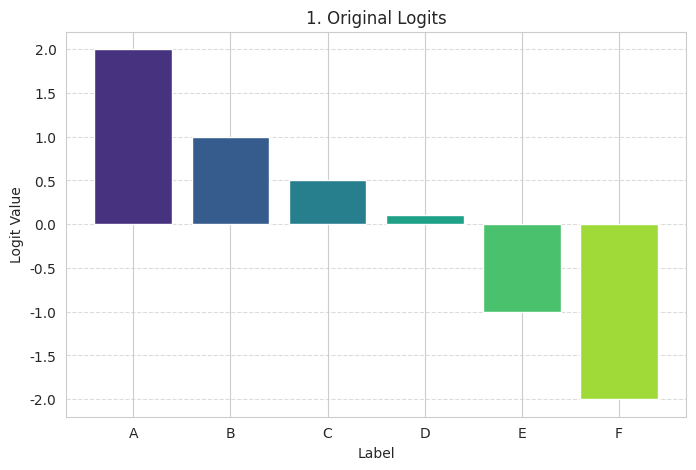



--- After Penalty ---
Logit Value 值: [ 0.5  1.   0.5  0.1 -2.5 -2. ]


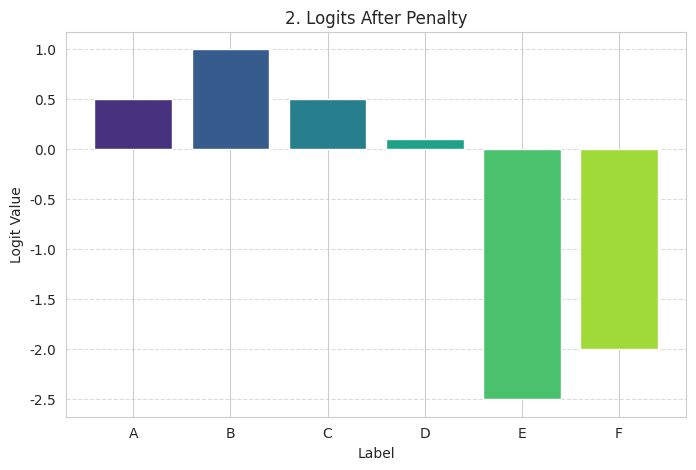



--- After Bias ---
Logit Value 值: [ 0.5  1.   1.3  0.9 -2.5 -2. ]


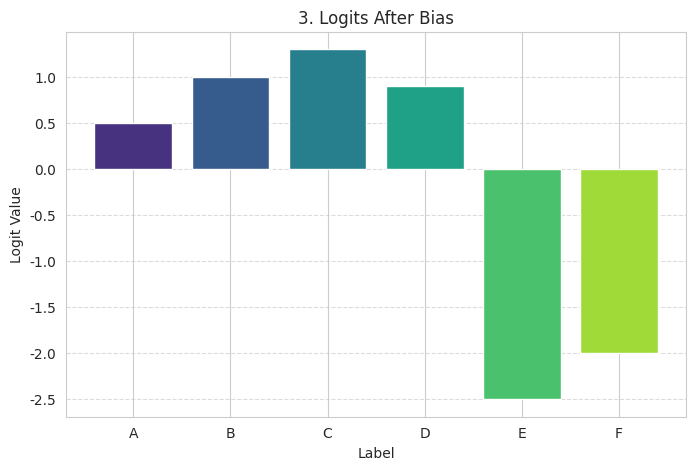



--- After Temperature Scaling ---
Logit Value 值: [ 1.   2.   2.6  1.8 -5.  -4. ]


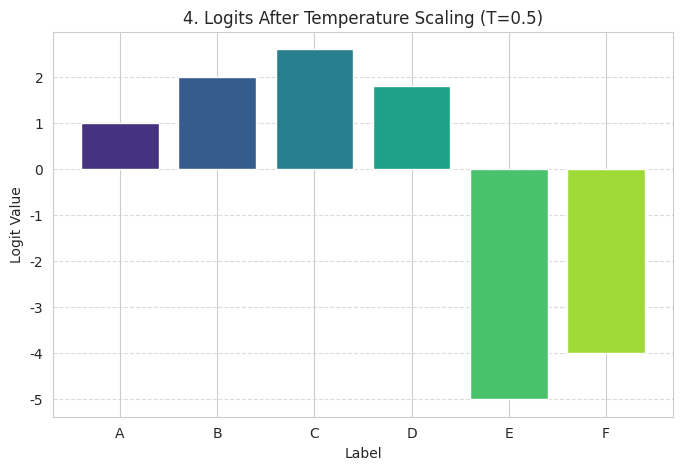



--- After Softmax ---
Probability 值: [9.16920419e-02 2.49244811e-01 4.54153657e-01 2.04064392e-01
 2.27281848e-04 6.17816119e-04]


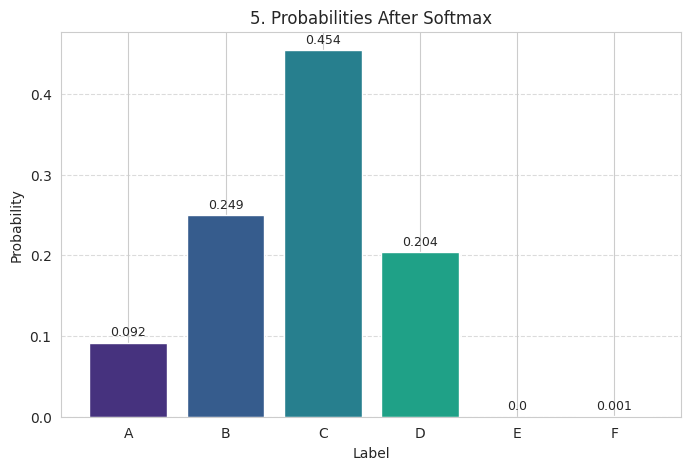



--- After Top-K ---
Probability 值: [0.         0.27466117 0.50046528 0.22487355 0.         0.        ]


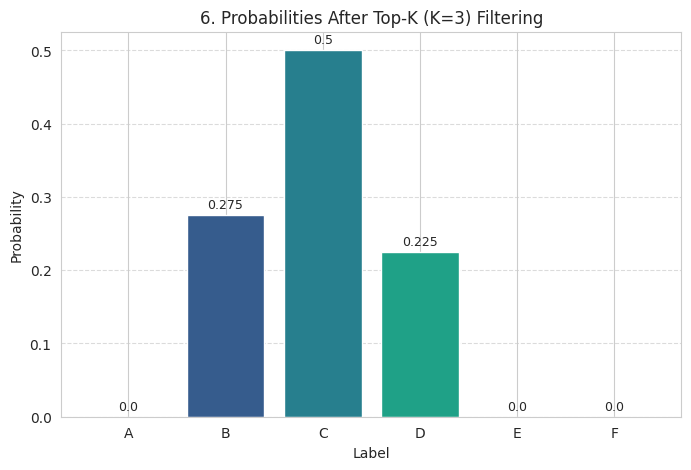



--- After Top-P ---
Probability 值: [0.         0.35434369 0.64565631 0.         0.         0.        ]


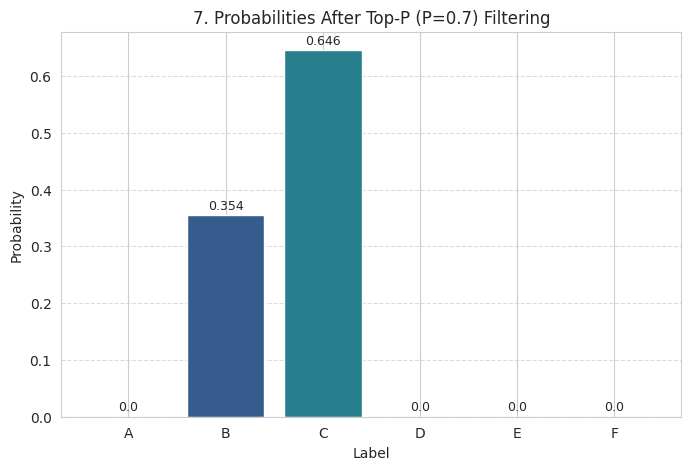



最终采样标签 (经过所有转换，包括 Top-K): C


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文字体和样式
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

def plot_bar_chart(data, labels, title, ylabel, step_name, is_probability=False):
    """辅助函数，用于绘制 logits 或概率的条形图。"""
    plt.figure(figsize=(8, 5))
    colors = sns.color_palette("viridis", len(data))
    bars = plt.bar(labels, data, color=colors)
    plt.xlabel('Label')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    if is_probability:
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 3), ha='center', va='bottom', fontsize=9)
    print(f"--- {step_name} ---")
    print(f"{ylabel} 值: {data}")
    plt.show()
    print("\n")

# 1. 定义原始 logits 和标签
original_logits = np.array([2.0, 1.0, 0.5, 0.1, -1.0, -2.0])
labels = ['A', 'B', 'C', 'D', 'E', 'F']
current_logits = np.copy(original_logits)

# 绘制原始 Logits
plot_bar_chart(current_logits, labels, '1. Original Logits', 'Logit Value', 'Original Logits')

# 2. 应用惩罚
penalty_strength = 1.5
penalized_indices = [0, 4]
current_logits = apply_penalty(current_logits, penalty_strength, penalized_indices)

# 绘制施加惩罚后的 Logits
plot_bar_chart(current_logits, labels, '2. Logits After Penalty', 'Logit Value', 'After Penalty')

# 3. 应用偏置
bias_strength = 0.8
biased_indices = [2, 3]
current_logits = apply_bias(current_logits, bias_strength, biased_indices)

# 绘制施加偏置后的 Logits
plot_bar_chart(current_logits, labels, '3. Logits After Bias', 'Logit Value', 'After Bias')

# 4. 应用温度缩放
temperature_value = 0.5
current_logits = apply_temperature(current_logits, temperature_value)

# 绘制温度缩放后的 Logits
plot_bar_chart(current_logits, labels, f'4. Logits After Temperature Scaling (T={temperature_value})', 'Logit Value', 'After Temperature Scaling')

# 5. 应用 Softmax
current_probabilities = softmax(current_logits)
original_softmax_probs_for_top_p = np.copy(current_probabilities) # 为 Top-P 保存

# 绘制 Softmax 后的概率
plot_bar_chart(current_probabilities, labels, '5. Probabilities After Softmax', 'Probability', 'After Softmax', is_probability=True)

# 6. 应用 Top-K 过滤
k_value = 3
current_probabilities = top_k_filter(current_probabilities, k_value)

# 绘制 Top-K 过滤后的概率
plot_bar_chart(current_probabilities, labels, f'6. Probabilities After Top-K (K={k_value}) Filtering', 'Probability', 'After Top-K', is_probability=True)

# 7. 应用 Top-P 过滤 (使用 original_softmax_probs_for_top_p)
p_value = 0.7
top_p_probs = top_p_filter(original_softmax_probs_for_top_p, p_value)

# 绘制 Top-P 过滤后的概率
plot_bar_chart(top_p_probs, labels, f'7. Probabilities After Top-P (P={p_value}) Filtering', 'Probability', 'After Top-P', is_probability=True)

# 8. 加权采样
sampled_label = weighted_sample(current_probabilities, labels)
print(f"最终采样标签 (经过所有转换，包括 Top-K): {sampled_label}")

## 2 温度值对采样的影响

温度值会影响结果输出。

特点：低温处理能够让概率大值更加突出，输出变得可预测、连贯，但也可能变得重复和缺乏创造力；高温处理输出会更加多样、有创意，但会变得不连贯或出现事实性错误。

通过plot将T影响绘制成图：

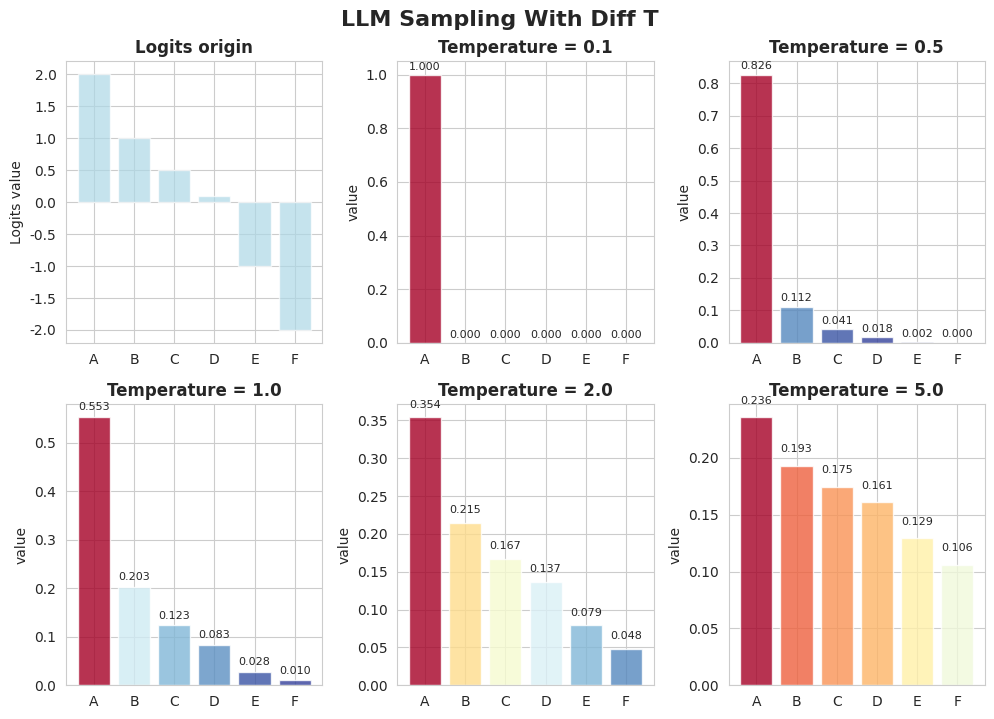

不同温度下的概率分布对比：
词汇       原始Logits     T=0.1      T=0.5      T=1.0      T=2.0      T=5.0     
A        2.000        1.0000     0.8262     0.5529     0.3541     0.2358    
B        1.000        0.0000     0.1118     0.2034     0.2148     0.1930    
C        0.500        0.0000     0.0411     0.1234     0.1673     0.1747    
D        0.100        0.0000     0.0185     0.0827     0.1369     0.1612    
E        -1.000       0.0000     0.0020     0.0275     0.0790     0.1294    
F        -2.000       0.0000     0.0003     0.0101     0.0479     0.1059    


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文字体和样式
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

def softmax_with_temperature(logits, temperature=1.0):
    """
    带温度的softmax函数
    """
    # 应用温度缩放
    scaled_logits = logits / temperature
    # 减去最大值以提高数值稳定性
    scaled_logits = scaled_logits - np.max(scaled_logits)
    # 计算softmax
    exp_values = np.exp(scaled_logits)
    probabilities = exp_values / np.sum(exp_values)
    return probabilities

# 原始logits（模型输出的原始分数）
original_logits = np.array([2.0, 1.0, 0.5, 0.1, -1.0, -2.0])
labels = ['A', 'B', 'C', 'D', 'E', 'F']

# 不同的温度值
temperatures = [0.1, 0.5, 1.0, 2.0, 5.0]

# 计算不同温度下的概率分布
results = {}
for temp in temperatures:
    results[temp] = softmax_with_temperature(original_logits, temp)

# 绘制结果
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes = axes.flatten()

# 绘制原始logits
axes[0].bar(labels, original_logits, color='lightblue', alpha=0.7)
axes[0].set_title('Logits origin', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Logits value')

# 绘制不同温度下的概率分布
for i, temp in enumerate(temperatures, 1):
    probs = results[temp]
    colors = plt.cm.RdYlBu_r(probs / np.max(probs))  # 根据概率值着色

    bars = axes[i].bar(labels, probs, color=colors, alpha=0.8)
    axes[i].set_title(f'Temperature = {temp}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('value')

    # 在柱子上显示概率值
    for bar, prob in zip(bars, probs):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{prob:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.suptitle('LLM Sampling With Diff T', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# 打印详细数据对比
print("=" * 60)
print("不同温度下的概率分布对比：")
print("=" * 60)
print(f"{'词汇':<8} {'原始Logits':<12}", end="")
for temp in temperatures:
    print(f" {'T='+str(temp):<10}", end="")
print()

for j, label in enumerate(labels):
    print(f"{label:<8} {original_logits[j]:<12.3f}", end="")
    for temp in temperatures:
        print(f" {results[temp][j]:<10.4f}", end="")
    print()

## 3 计算顺序对结果影响

softmax与TopK的计算顺序对结果影响。

分别绘制不同TopK取值下的概率图。


========================= K=2 =========================
输入logits: [ 2.   1.   0.5  0.1 -1.  -2. ]
K值: 2

详细结果:
索引     原始值        完整Softmax      先TopK后Softmax      先SoftK后TopK        差异      
------------------------------------------------------------------------------------------
0      2.000      0.5529         0.7311             0.5529             0.1782  
1      1.000      0.2034         0.2689             0.2034             0.0655  
2      0.500      0.1234         0.0000             0.0000             0.0000  
3      0.100      0.0827         0.0000             0.0000             0.0000  
4      -1.000     0.0275         0.0000             0.0000             0.0000  
5      -2.000     0.0101         0.0000             0.0000             0.0000  

关键观察:
方法1 (先TopK后Softmax) 保留的索引: [np.int64(0), np.int64(1)]
方法2 (先SoftK后TopK) 保留的索引: [np.int64(0), np.int64(1)]
✓ 两种方法选择了相同的topK索引

总概率 - 方法1: 1.000000, 方法2: 0.756286


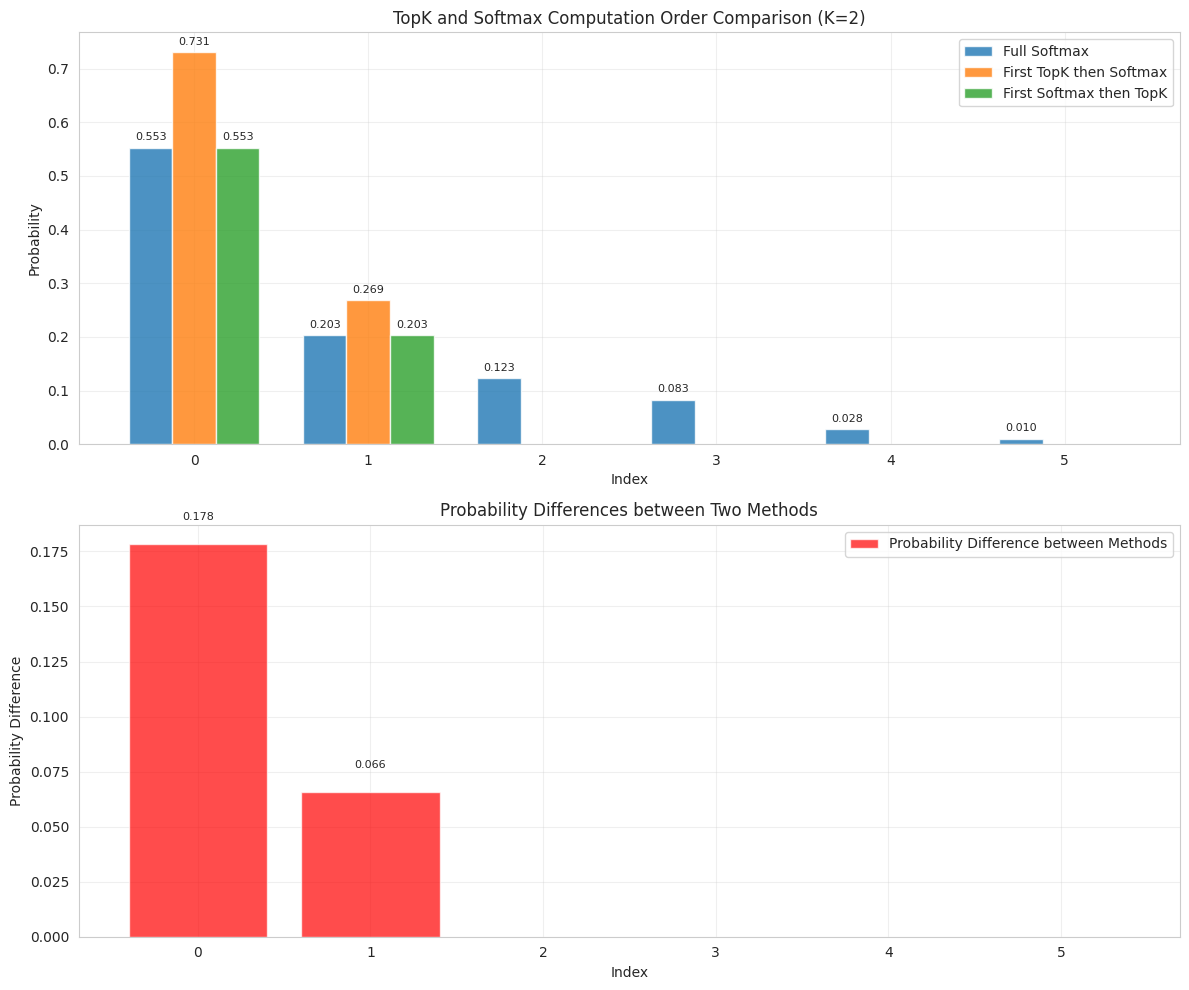

总体差异统计:
  - 总差异: 0.243714
  - 最大单一差异: 0.178169

========================= K=3 =========================
输入logits: [ 2.   1.   0.5  0.1 -1.  -2. ]
K值: 3

详细结果:
索引     原始值        完整Softmax      先TopK后Softmax      先SoftK后TopK        差异      
------------------------------------------------------------------------------------------
0      2.000      0.5529         0.6285             0.5529             0.0756  
1      1.000      0.2034         0.2312             0.2034             0.0278  
2      0.500      0.1234         0.1402             0.1234             0.0169  
3      0.100      0.0827         0.0000             0.0000             0.0000  
4      -1.000     0.0275         0.0000             0.0000             0.0000  
5      -2.000     0.0101         0.0000             0.0000             0.0000  

关键观察:
方法1 (先TopK后Softmax) 保留的索引: [np.int64(0), np.int64(1), np.int64(2)]
方法2 (先SoftK后TopK) 保留的索引: [np.int64(0), np.int64(1), np.int64(2)]
✓ 两种方法选择了相同的topK索引

总概率 - 方法1: 1.000000, 方法2: 0.879

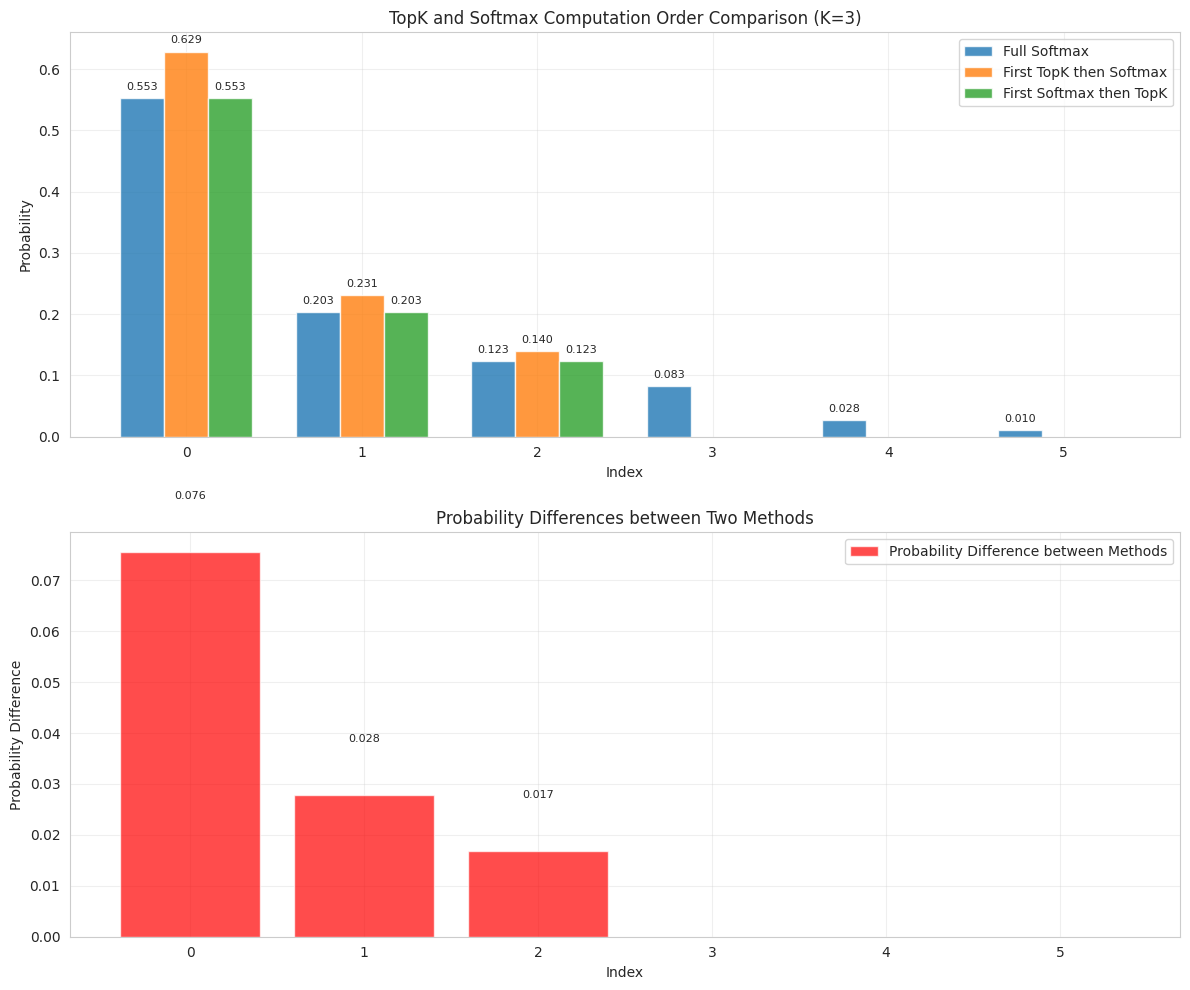

总体差异统计:
  - 总差异: 0.120348
  - 最大单一差异: 0.075643

========================= K=4 =========================
输入logits: [ 2.   1.   0.5  0.1 -1.  -2. ]
K值: 4

详细结果:
索引     原始值        完整Softmax      先TopK后Softmax      先SoftK后TopK        差异      
------------------------------------------------------------------------------------------
0      2.000      0.5529         0.5745             0.5529             0.0216  
1      1.000      0.2034         0.2114             0.2034             0.0080  
2      0.500      0.1234         0.1282             0.1234             0.0048  
3      0.100      0.0827         0.0859             0.0827             0.0032  
4      -1.000     0.0275         0.0000             0.0000             0.0000  
5      -2.000     0.0101         0.0000             0.0000             0.0000  

关键观察:
方法1 (先TopK后Softmax) 保留的索引: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
方法2 (先SoftK后TopK) 保留的索引: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
✓ 两种方法选择了相同的topK索引

总概率 -

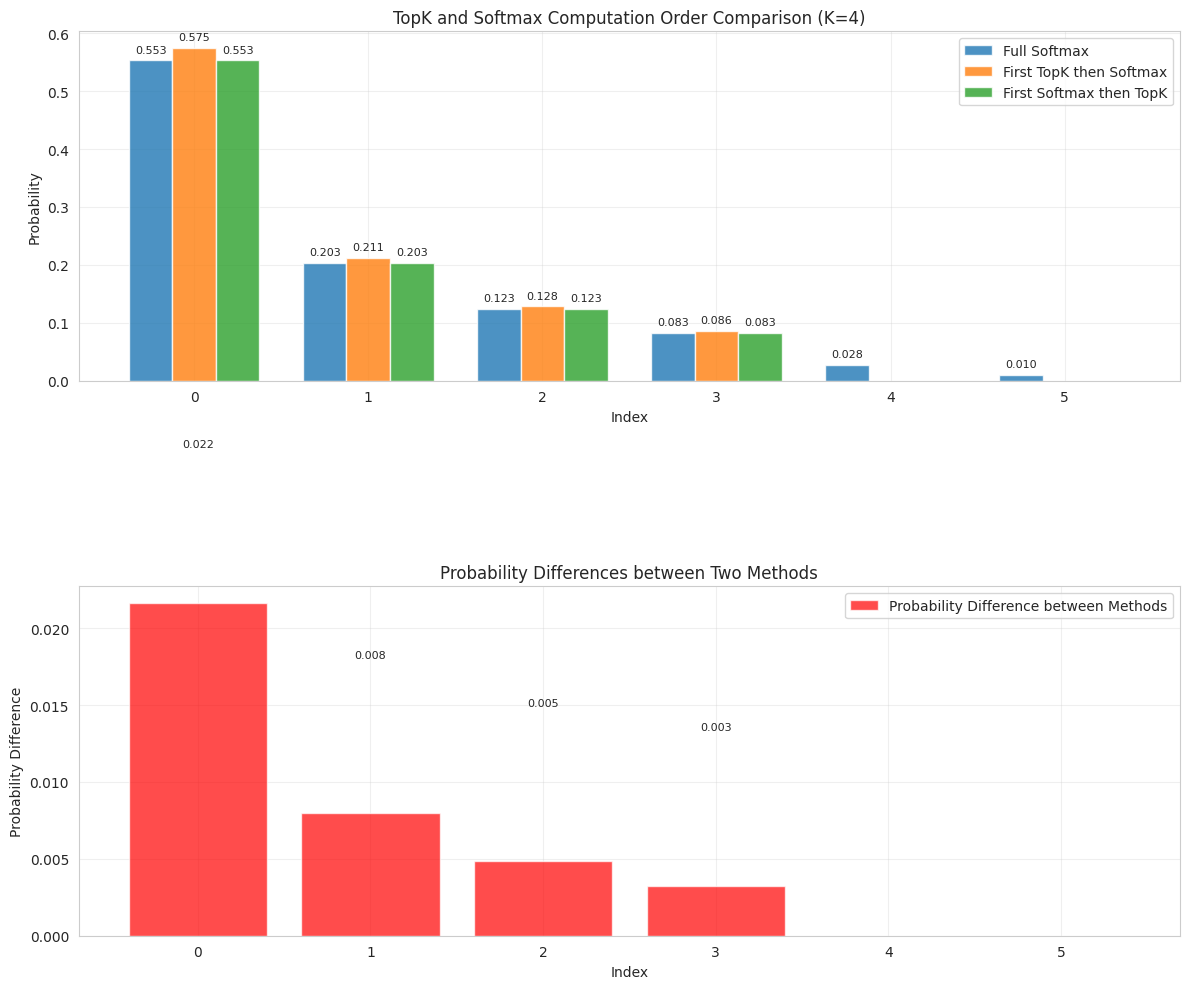

总体差异统计:
  - 总差异: 0.037653
  - 最大单一差异: 0.021633


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(x):
    """计算softmax"""
    exp_x = np.exp(x - np.max(x))  # 减去最大值以防止数值溢出
    return exp_x / np.sum(exp_x)

def top_k_softmax(logits, k):
    """先进行topK筛选，然后计算softmax"""
    # 获取topK索引
    topk_indices = np.argsort(logits)[-k:]
    # 获取topK值
    topk_logits = logits[topk_indices]
    # 计算softmax
    topk_probs = softmax(topk_logits)

    # 创建完整的概率数组（非topK位置为0）
    full_probs = np.zeros_like(logits)
    full_probs[topk_indices] = topk_probs

    return full_probs

def softmax_top_k(logits, k):
    """先计算softmax，然后进行topK筛选"""
    # 首先计算完整的softmax
    all_probs = softmax(logits)
    # 获取topK索引
    topk_indices = np.argsort(all_probs)[-k:]
    # 创建结果数组（非topK位置为0）
    result = np.zeros_like(logits)
    result[topk_indices] = all_probs[topk_indices]

    return result

def plot_comparison(logits, k):
    """绘制比较图表"""

    # 计算两种方法的结果
    method1_probs = top_k_softmax(logits, k)  # 先TopK后Softmax
    method2_probs = softmax_top_k(logits, k)  # 先Softmax后TopK
    original_softmax = softmax(logits)        # 完整的Softmax

    # 创建图表
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # 第一个子图：概率分布比较
    x = np.arange(len(logits))
    width = 0.25

    ax1.bar(x - width, original_softmax, width, label='Full Softmax', alpha=0.8)
    ax1.bar(x, method1_probs, width, label='First TopK then Softmax', alpha=0.8)
    ax1.bar(x + width, method2_probs, width, label='First Softmax then TopK', alpha=0.8)

    ax1.set_xlabel('Index')
    ax1.set_ylabel('Probability')
    ax1.set_title(f'TopK and Softmax Computation Order Comparison (K={k})')
    ax1.set_xticks(x)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 添加数值标签
    for i, (v1, v2, v3) in enumerate(zip(original_softmax, method1_probs, method2_probs)):
        if v1 > 0.01:
            ax1.text(i - width, v1 + 0.01, f'{v1:.3f}', ha='center', va='bottom', fontsize=8)
        if v2 > 0.01:
            ax1.text(i, v2 + 0.01, f'{v2:.3f}', ha='center', va='bottom', fontsize=8)
        if v3 > 0.01:
            ax1.text(i + width, v3 + 0.01, f'{v3:.3f}', ha='center', va='bottom', fontsize=8)

    # 第二个子图：差异分析
    differences = np.abs(method1_probs - method2_probs)
    ax2.bar(x, differences, color='red', alpha=0.7, label='Probability Difference between Methods')

    ax2.set_xlabel('Index')
    ax2.set_ylabel('Probability Difference')
    ax2.set_title('Probability Differences between Two Methods')
    ax2.set_xticks(x)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 添加差异值标签
    for i, diff in enumerate(differences):
        if diff > 0.001:
            ax2.text(i, diff + 0.01, f'{diff:.3f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

    return method1_probs, method2_probs, differences

def print_detailed_comparison(logits, k):
    """打印详细比较结果"""
    print("=" * 80)
    print(f"输入logits: {logits}")
    print(f"K值: {k}")
    print("=" * 80)

    # 计算各种结果
    method1_probs = top_k_softmax(logits, k)
    method2_probs = softmax_top_k(logits, k)
    original_softmax = softmax(logits)

    print("\n详细结果:")
    print(f"{'索引':<6} {'原始值':<10} {'完整Softmax':<14} {'先TopK后Softmax':<18} {'先SoftK后TopK':<18} {'差异':<8}")
    print("-" * 90)

    for i in range(len(logits)):
        diff = abs(method1_probs[i] - method2_probs[i])
        print(f"{i:<6} {logits[i]:<10.3f} {original_softmax[i]:<14.4f} "
              f"{method1_probs[i]:<18.4f} {method2_probs[i]:<18.4f} {diff:<8.4f}")

    print("\n关键观察:")
    # 查找topK索引
    topk_indices_method1 = np.where(method1_probs > 0)[0]
    topk_indices_method2 = np.where(method2_probs > 0)[0]

    print(f"方法1 (先TopK后Softmax) 保留的索引: {sorted(topk_indices_method1)}")
    print(f"方法2 (先SoftK后TopK) 保留的索引: {sorted(topk_indices_method2)}")

    if set(topk_indices_method1) == set(topk_indices_method2):
        print("✓ 两种方法选择了相同的topK索引")
    else:
        print("✗ 两种方法选择了不同的topK索引!")

    # 计算总概率
    total_prob_method1 = np.sum(method1_probs)
    total_prob_method2 = np.sum(method2_probs)
    print(f"\n总概率 - 方法1: {total_prob_method1:.6f}, 方法2: {total_prob_method2:.6f}")

# 主程序
if __name__ == "__main__":
    # 输入数据
    logits = np.array([2.0, 1.0, 0.5, 0.1, -1.0, -2.0])

    # 测试不同的K值
    k_values = [2, 3, 4]

    for k in k_values:
        print(f"\n{'='*25} K={k} {'='*25}")

        # 打印详细比较
        print_detailed_comparison(logits, k)

        # 绘制图表
        method1_probs, method2_probs, differences = plot_comparison(logits, k)

        # 计算总体差异统计
        total_diff = np.sum(differences)
        max_diff = np.max(differences)
        print(f"总体差异统计:")
        print(f"  - 总差异: {total_diff:.6f}")
        print(f"  - 最大单一差异: {max_diff:.6f}")